# Manufacuturer CNN Model Training Notebook

This notebook walks through the building of a dataset and model to classify aircraft manufacturers from images. The model used is a CNN model, built with 4 convolutional layers and 2 linear layers using PyTorch. 

First we start by importing all our neccessary libraries. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import models, transforms
from tqdm.notebook import tqdm
import albumentations as A

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# Data Location
data_path = 'gdrive/MyDrive/top_gun_dl/repo/data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Buidling our Dataset

In [4]:
# Create dataframe function from .txt files
def textfile_to_dataframe(path, filename, dataset):
    with open(data_path + filename) as f:
        data_lines = f.readlines()
  
    data = []
    for line in data_lines:
        line_list = line.split(maxsplit=1)
        img_num = line_list[0] + '.jpg'
        label = line_list[1]
        label = label.strip('\n')
        image_path = 'gdrive/MyDrive/top_gun_dl/repo/data/images/cropped/' + img_num
        row = [img_num, dataset, label, image_path]
        data.append(row)
  
    df = pd.DataFrame(data, columns=['image', 'dataset', 'label', 'path'])
    return df

In [5]:
# Creating dataframes from files
train_val_df = textfile_to_dataframe(data_path, 'images_manufacturer_trainval.txt', 'validation')
test_df = textfile_to_dataframe(data_path, 'images_manufacturer_test.txt', 'test')
len(train_val_df), len(test_df)

(6667, 3333)

In [6]:
# Rebalance Data
def shuffle_train_val(data, ratio=.25):
    train, val = train_test_split(data, test_size=ratio)
    return train, val

train_df, valid_df = shuffle_train_val(train_val_df, ratio=.25)
len(train_df), len(valid_df), len(test_df)

(5000, 1667, 3333)

In [7]:
# Let's create a Dataset for our Aircraft images! 
class SimpleDataset(Dataset):
    def __init__(self, df, class_dict, resize_image=True, augment=False):
        self.df = df
        self.label_dict = class_dict
        self.resize_image = resize_image
        self.augment = augment
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx): 
        row = self.df.iloc[idx]
                
        # read the img
        path = row['path']
        img = cv2.imread(path)
        
        # resize the image ... perhaps we do not want to do this?
        if self.resize_image:
            try:
                img = cv2.resize(img, (256,256))
            except:
                print(path)

        # data augmentation
        if self.augment == True:
            transform = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5)], 
                A.GaussianBlur(p=0.5), 
                A.ChannelShuffle(p=0.5))
            img = transform(image=img)['image']
        
        # convert to RGB ... neccessary
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # move color channels to correct spot ... neccessary
        img = np.transpose(img, (2, 0, 1))
        
        # convert to [0,1] scale ... neccessary
        img = torch.tensor(img / 255.).float()
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [8]:
# We will also need to label encode the classes, so let's create a dictionary for that
classes = set()
with open(data_path+'manufacturers.txt', 'r') as manufacturers: 
  for line in manufacturers: 
     classes.add(line.strip())

# Creating the label dictionary for all classes
class_dict = {c:i for i,c in enumerate(list(classes))} # class to ID
print(f'Number of Classes the model will predict: {len(class_dict.values())}')

Number of Classes the model will predict: 30


### Building Our CNN Model

In [9]:
class CNN(nn.Module):
    def __init__(self, class_dict):
        super().__init__()
        
        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=2, padding=1)
        
        # linear layers
        self.linear1 = nn.Linear(16384, 100)
        self.linear2 = nn.Linear(100, len(class_dict.values()))
        
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # activation
        self.relu = nn.ReLU()
        
        # for unrolling into FC layer
        self.unroll = nn.Flatten()
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)

        # unroll x for FC layer
        x = self.linear1(self.unroll(x))
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

### Training Functions and Execution

In [10]:
# Model Training and Validation Functions

def validate_model(model, loss, dl):
    losses = []
    accs = []
    topk_list = []
    truey_list = []
    model.to(device)
    model.eval()

    # True Accuracy %
    for img, label in tqdm(dl):
      # convert data to GPU
        img, label = img.to(device), label.to(device)
        y = label.cpu().detach().numpy()
        truey_list.extend(y)
        y_hat = model(img)
        
        all_preds = torch.argmax(y_hat, dim=1).cpu().detach().numpy()
        L = loss(y_hat, label)
        losses.append(L.item())
        accs.append(accuracy_score(y, all_preds))
    return np.mean(losses), np.mean(accs)

  
def train_model(model, optim, loss, train_df, valid_df, epochs, \
                BatchSize=8, shuffle_epochs=False, shuffle_count=3, 
                split_ratio=.25):
    # train the model and track test loss and accuracy for comparisons
    epoch_losses = []
    epoch_accs = []
    model.to(device)
    model.train()

    # initial datasets and dataloaders for training
    train_ds = SimpleDataset(train_df, class_dict, resize_image=True)
    train_dl = DataLoader(train_ds, batch_size=BatchSize, shuffle=True)
    val_ds = SimpleDataset(valid_df, class_dict, resize_image=True)
    val_dl = DataLoader(val_ds, batch_size=BatchSize, shuffle=True)

    for e in tqdm(range(epochs)):
        # reshuffle training data if desired
        if shuffle_epochs and e%shuffle_count == 0: 
            train_df = train_df.append(valid_df)
            train_df, valid_df = shuffle_train_val(train_df, ratio=split_ratio)
            train_ds = SimpleDataset(train_df, class_dict, resize_image=True)
            train_dl = DataLoader(train_ds, batch_size=BatchSize, shuffle=True)
            val_ds = SimpleDataset(valid_df, class_dict, resize_image=True)
            val_dl = DataLoader(val_ds, batch_size=BatchSize, shuffle=True)

        train_losses = []
        # perform training
        for img, label in tqdm(train_dl):
            img, label = img.to(device), label.to(device) # convert data to GPU
            model.train()
            label_pred = model(img)
            L = loss(label_pred, label)
            train_losses.append(L.item())

            optim.zero_grad()
            L.backward()
            optim.step()

        test_loss, test_acc = validate_model(model, loss, val_dl)
        epoch_losses.append(test_loss), epoch_accs.append(test_acc)
        print(f'''Epoch {e+1} - Training:{np.mean(train_losses)}, Test:{test_loss}, Acc:{test_acc}''')
    return model, epoch_losses, epoch_accs

In [11]:
# Establishing our initial model 
model = CNN(class_dict)

In [12]:
# Initializing optimizer and defining loss function
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training the model    
model, test_losses, test_accs = train_model(model, optimizer, loss, train_df, valid_df, \
                                           epochs=8, shuffle_epochs=True, split_ratio=.25)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1 - Training:2.90761268825531, Test:2.8344924204657524, Acc:0.20673843700159486


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2 - Training:2.605767102813721, Test:2.4061568319512325, Acc:0.2677432216905901


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3 - Training:2.0891844474792483, Test:2.0789292571647318, Acc:0.3546650717703349


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 4 - Training:1.7001342609405519, Test:1.5930521188740525, Acc:0.4904306220095694


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 5 - Training:1.2777217661857605, Test:1.607030206462413, Acc:0.5015948963317385


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 6 - Training:0.9037733892679215, Test:1.6364755453675557, Acc:0.5283094098883572


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 7 - Training:0.8937246710658073, Test:0.8643557451772348, Acc:0.7414274322169058


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 8 - Training:0.5553910287201405, Test:0.9523302888470974, Acc:0.7031499202551833


In [15]:
torch.cuda.empty_cache() # Clearing out RAM

# Create test dataset and dataloaders to measure performance on unseen data
test_ds = SimpleDataset(test_df, class_dict, resize_image=True, augment=False)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False) # Smaller batch size needed for memory

# Checking model performance on unseen data
final_loss, final_acc = validate_model(model, loss, test_dl)
print(f'Final Loss:{final_loss}, Acc:{final_acc}')

  0%|          | 0/209 [00:00<?, ?it/s]

Final Loss:2.218414310134199, Acc:0.49826555023923447


In [16]:
# Adding a few more epochs with lower learning rate
optimizer_lower = optim.Adam(model.parameters(), lr = 0.00001)
model, test_losses_lower, test_accs_lower  = train_model(model, optimizer_lower, loss, train_df, valid_df, \
                                            epochs=3, shuffle_epochs=True, split_ratio=.25)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 1 - Training:0.4419476089730859, Test:0.39310572428281226, Acc:0.8744019138755981


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 2 - Training:0.4000971965610981, Test:0.3788853929908367, Acc:0.8809808612440191


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/209 [00:00<?, ?it/s]

Epoch 3 - Training:0.38232228839248417, Test:0.3710268632459797, Acc:0.8863636363636364


In [17]:
torch.cuda.empty_cache() # Clearing out RAM

# Checking model performance on unseen data
final_loss, final_acc = validate_model(model, loss, test_dl)
print(f'Final Loss:{final_loss}, Acc:{final_acc}')

  0%|          | 0/209 [00:00<?, ?it/s]

Final Loss:2.17737163681733, Acc:0.5203947368421052


### Model Evaluation

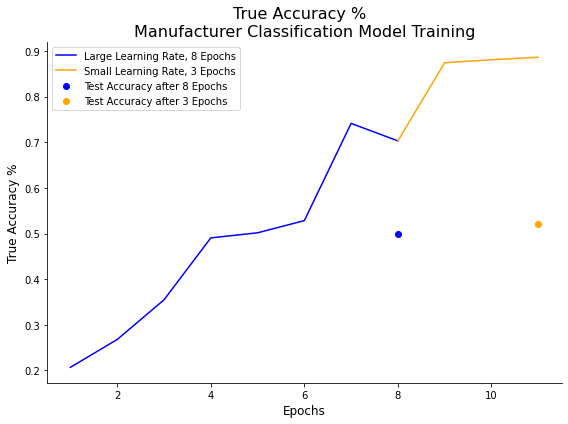

In [70]:
# Creating a plot to visualize the improvement over time
fig, ax = plt.subplots(figsize=(8,6))
ax.plot([1,2,3,4,5,6,7,8], test_accs, label='Large Learning Rate, 8 Epochs', c='b')
ax.scatter([8], [.4982], label='Test Accuracy after 8 Epochs', c='b')
ax.plot([9,10,11], test_accs_lower, label='Small Learning Rate, 3 Epochs', c='orange')
ax.scatter([11], [.5203], label='Test Accuracy after 3 Epochs', c='orange')
ax.plot([8,9], [test_accs[-1],test_accs_lower[0]], c='orange')
ax.set_title('True Accuracy %  \nManufacturer Classification Model Training', size=16)
ax.set_ylabel('True Accuracy %', size=12)
ax.set_xlabel('Epochs', size=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.tight_layout()
plt.savefig('gdrive/MyDrive/top_gun_dl/manufacturer_model_performance.png')
plt.show()